# Motivation

This notebook aims to show how to use Sklearn Pipelines at their full capacity by implementing a yearly wheat yield forecasting model.

We have used the **dataset** provided by [Pangaea](https://doi.pangaea.de/10.1594/PANGAEA.909132), which tracks global yearly yields for various plants from 1981 to 2016.

In this notebook, we showed how to use the following classes/functions from Sklearn to build a professional machine learning pipeline:
* [TransformerMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html)
* [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html)
* [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html)
* [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
* [FeatureUnion](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html)
* [TransformedTargetRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html)
---
We will only go into the details of some items stated above and just show how to use them in an actual application. If you want to read the basics, here are a few articles I recommend:
* https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a
* https://medium.com/towards-data-science/10-sklearn-gems-buried-in-the-docs-waiting-to-be-found-ad95a8fabdfd

## Summary of Basic Concepts

Everything is revolved around the `Pipeline` object.

A `Pipeline` contains multiple `Estimators`.

An `Estimator` can have the following properties:
* can learn from the data -> using the `fit()` method
* can transform the data -> using the `transform()` method. This is known as a `Transformer` (no, not the robots, just a `Class`).
* can predict from new data -> using the `predict()` method. This is known as a `Predictor`.

**NOTE 1:** We can have `Transformers` that do not have a `fit()` method. Therefore, those classes are not parameterized and follow the principles of a pure function. Usually, those types of transformers are helpful when doing feature engineering (e.g., we can multiply two different columns without learning anything before using the `fit()` method).

**NOTE 2:** The `Pipeline` object inherits the methods from the last `Estimator` within the `Pipeline`.

**NOTE 3:** If you want to add a model to your pipeline, it must be your `Pipeline` last element. I will show you a trick on how to perform postprocessing operations on the model's predictions using [TransformedTargetRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html).

# Load Packages

In [1]:
from sklearn import set_config

# By setting the display of Sklearn to "diagram," we can quickly visualize the pipeline diagram.
set_config(display="diagram")

In [2]:
import glob
import re
import os
import logging

import pandas as pd
import numpy as np
import xarray as xr

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

from functools import partial
from typing import Optional, Union, Tuple

We will use the logger instead of the print function. If you want to turn off the pipeline's verbose messages, just set the level to `logging.INFO`.

In [3]:
logging.basicConfig(level=logging.DEBUG)

logger = logging.getLogger("sklearn-pipelines")
logger.info("Logger configured")

INFO:sklearn-pipelines:Logger configured


# Constants

In [4]:
# It is the number of wheat yields from the past we will use to predict the yield for the following year.
NUM_OBSERVED_POINTS: int = 5
# It is the number of years used within the test split.
SIZE_TEST_SPLIT: int = 4

# Extract Data

In [5]:
def extract(root_dir: str) -> pd.DataFrame:
    """Function that takes the root dir of a plant (e.g., wheat, maize, etc.) and extracts everything into a DataFrame."""

    year_yields = {}
    for file_path in glob.glob(os.path.join(root_dir, "*.nc4")):
        file_name = os.path.split(file_path)[1]
        year_match = re.match(r"^yield_(\d+?)\.nc4$", file_name)
        year = year_match.group(1)
        year = int(year)

        ds = xr.open_dataset(file_path)
        df = ds.to_dataframe()
        mean_year_value = df.mean().iloc[0]

        year_yields[year] = {
            "mean_yield": mean_year_value,
            "locations": len(df.dropna())
        }

    year_yields = pd.DataFrame.from_dict(data=year_yields, orient='index')
    year_yields = year_yields.sort_index()

    return year_yields

In [6]:
yields = extract("/mnt/c/Users/nisar/taxi_demand_predictor/yields/wheat")
yields.head()

,mean_yield,locations
1981,1.678322,2346
1982,3.048540,12628
1983,3.226099,12641
1984,3.340139,12627
1985,3.297000,12624


In [7]:
yields.tail()

,mean_yield,locations
2012,4.026584,10667
2013,4.190502,10598
2014,4.151844,10598
2015,3.911601,9593
2016,4.293674,10598


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/mnt/c/Users/nisar/taxi_demand_predictor/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/mnt/c/Users/nisar/taxi_demand_predictor/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/mnt/c/Users/nisar/taxi_demand_predictor/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, 

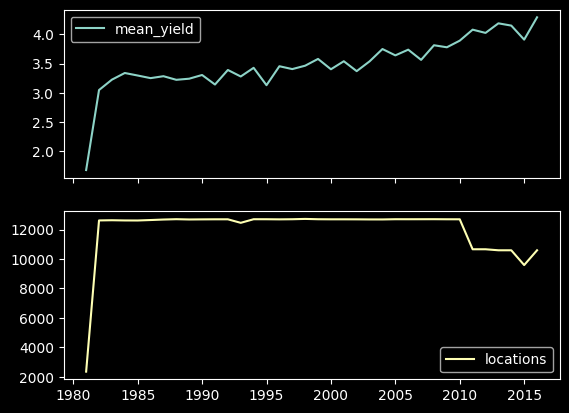

In [8]:
yields.plot(subplots=True);

# Data Preprocessing

## Pick Ground Truth
Because time series forecasting is a form of unsupervised learning, we have to predict a datapoint at $T_{n}$ using information starting from $T_{n-1}$ until $T_{0}$. Therefore, in the beginning, we will consider the same features and labels. But during the preprocessing steps, we will change the features to forecast the next point in time.

In [9]:
X, y = yields.copy(), yields.copy()

## Split Data: Train & Test

In [10]:
class TimeSeriesSplitter:
    """The class is used to split the time series between train and test and stores the indices for future reconstruction."""

    def __init__(self, num_observed_points: int):
        """

        Args:
            num_observed_points: The number of observed points from the past that are used to forecast the future.
        """

        self.num_observed_points = num_observed_points

        self.X_train: Optional[pd.DataFrame] = None
        self.y_train: Optional[pd.DataFrame] = None
        self.X_test: Optional[pd.DataFrame] = None
        self.y_test: Optional[pd.DataFrame] = None


    def split(self, X: pd.DataFrame, y: pd.DataFrame, test_num_years: int = 5) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
        """Split the data between train and test."""

        start_train_num_years = X.index.min()
        end_train_num_years = X.index.max() - test_num_years
        assert end_train_num_years > 0, "The number of training months is 0."


        X_train_mask = X.index <= end_train_num_years
        y_train_mask = (y.index >= start_train_num_years + self.num_observed_points) & (y.index <= end_train_num_years) # Remove self.num_observed_points from the target, because we cannot predict those items due to lack of data. We need at least self.num_observed_points to forecast.
        X_test_mask = X.index > end_train_num_years - (self.num_observed_points + 1)  # Add self.num_observed items to the features so we can forecast the first element from the future based on what we know. Also add another +1 element for the differentiation operation.
        y_test_mask = y.index > end_train_num_years - 1 # Subtract -1 for the differentiation operation. (meaning differencing)

        self.X_train = X.loc[X_train_mask]
        self.y_train = y.loc[y_train_mask]["mean_yield"]

        self.X_test = X.loc[X_test_mask]
        self.y_test = y.loc[y_test_mask]["mean_yield"]

        return self.X_train, self.y_train, self.X_test, self.y_test

    def attach_indices(self, y: Union[pd.Series, np.ndarray], split: str = "test") -> pd.Series:
        """Take the predictions of the model and attach the initial indices."""

        assert split in ("train", "test")
        assert self.y_train is not None and self.y_test is not None

        if isinstance(y, np.ndarray):
            y = pd.Series(y)

        if split == "train":
            y = y.set_axis(self.y_train.index)
        else:
            y = y.set_axis(self.y_test.index)

        y = y.rename(self.y_train.name)

        return y

In [11]:
time_series_splitter = TimeSeriesSplitter(num_observed_points=NUM_OBSERVED_POINTS)
X_train, y_train, X_test, y_test = time_series_splitter.split(X, y, test_num_years=SIZE_TEST_SPLIT)

In [12]:
X_train.index.min(), X_train.index.max(), X_train.index.max() - X_train.index.min() + 1

(1981, 2012, 32)

In [14]:
y_train.index.min(), y_train.index.max(), y_train.index.max() - y_train.index.min() + 1

(1986, 2012, 27)

In [15]:
X_test.index.min(), X_test.index.max(), X_test.index.max() - X_test.index.min() + 1

(2007, 2016, 10)

In [16]:
y_test.index.min(), y_test.index.max(), y_test.index.max() - y_test.index.min() + 1

(2012, 2016, 5)

## Stationarity Pipeline

Pipeline used on a time series to make it stationary. More concrete it will remove periodicity and standardize the mean and variance across time. [Here](https://stats.stackexchange.com/questions/407062/log-transformation-of-ts-stationary-time-series) you can read more about this.

In this step we will show how to use:
* [TransformerMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html)
* [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html)
* [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html)

Check out the pydocs for more information about the implementation.

In [100]:
X_train.head()

,mean_yield,locations
1981,1.678322,2346
1982,3.048540,12628
1983,3.226099,12641
1984,3.340139,12627
1985,3.297000,12624


In [17]:
class LogTransformer(BaseEstimator, TransformerMixin):
    """
    Custom log transformation that follows the Sklearn interface to be used in a Pipeline.

    Here is a short summary of the supported interface and of what every function is doing:
    * fit - used to learn from the data
    * transform - used to transform the data
    * fit_transform - learn and transform the data. This function is inherited from TransformerMixin
    * inverse_transform - used to reverse the transformation

    NOTE 1: This statement is always true: x == inverse_transform(transform(x)) - with a small tolerance accepted.

    NOTE 2: The targets (e.g., y) are passed only in the fit() method. At the transform() and inverse_transform(), only the features (e.g., X) are given as input.

    """

    def fit(self, X: pd.DataFrame, y: Optional[Union[pd.DataFrame, pd.Series]] = None) -> "LogTransformer":
        """In this scenario, the fit method isn't doing anything. But it must be implemented. This is a scenario of an estimator without parameters."""

        logger.debug(f"LogTransformer X (fit): {X.shape}")
        if y is not None:
            logger.debug(f"LogTransformer y (fit): {y.shape}")

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """Apply log on all the cells of the DataFrame."""

        X_log = np.log(X + 1e-27)

        logger.debug(f"LogTransformer (transform): {X_log.shape}")

        return X_log

    def inverse_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """Inverse the log of every cell of the DataFrame."""

        X_exp = np.exp(X) - 1e-27

        logger.debug(f"LogTransformer (inverse_transform): {X_exp.shape}")

        return X_exp


class DifferenceTransformer(BaseEstimator, TransformerMixin):
    """Custom differentiation transformation that follows the Sklearn interface to be used in a Pipeline."""

    def __init__(self, num_observed_points: int):
        """

        Args:
            num_observed_points: The number of observed points from the past that are used to forecast the future.
        """

        self.num_observed_points = num_observed_points
        self.X_train = None

    def fit(self, X: Optional[Union[pd.DataFrame, pd.Series]], y: Optional[Union[pd.DataFrame, pd.Series]] = None) -> "DifferenceTransformer":
        """In this case by fitting we just keep a copy of the train data to reconstruct the time series on the inverse_transform() operation."""

        logger.debug(f"DifferenceTransformer X (fit): {X.shape}")
        if y is not None:
            logger.debug(f"DifferenceTransformer y (fit): {y.shape}")

        self.X_train = X.copy()

        return self

    def transform(self, X: Optional[Union[pd.DataFrame, pd.Series]]) -> pd.DataFrame:
        """Apply the differentiation operation."""

        X_diff = X.diff(periods=1)
        X_diff = X_diff.iloc[1:]

        logger.debug(f"DifferenceTransformer (transform): {X_diff.shape}")

        return X_diff

    def inverse_transform(self, X: Optional[Union[np.ndarray, pd.DataFrame, pd.Series]]) -> pd.DataFrame:
        """Inverse the differentiation operation."""

        if isinstance(X, np.ndarray):
            if len(X.shape) == 1:
                X = pd.Series(X)
            elif len(X.shape) == 2:
                X = pd.DataFrame(X)
            else:
                raise RuntimeError(f"Shape of X not supported: {X.shape}")

        if len(X) == len(self.X_train) - 1:
            first_values = self.X_train.iloc[[0]]
        else:
            first_values = self.X_train.iloc[[-(self.num_observed_points + 1)]]

        X_reversed = pd.concat([first_values, X])
        X_reversed = X_reversed.cumsum(axis=0)

        logger.debug(f"DifferenceTransformer (inverse_transform): {X_reversed.shape}")

        return X_reversed


def time_series_imputer(X: Union[np.ndarray, pd.DataFrame], method: str = "bfill"):
    """
    Impute missing values of the time series.

    This time we will build a Sklearn Transformation using a plain function.
    This function must take a DataFrame/Series/NumPy array as input and return a single structure.
    To avoid unexpected behavior, this should be a pure function.

    It is helpful to use a plain function when your transformation doesn't need an implementation for fit() and inverse_transform().

    Afterward, we will wrap this function with `FunctionTransformer`, letting us use it in a Sklearn Pipeline object.

    NOTE: Because this function is equal to the transform() method from the approach that uses Classes, only the features (e.g., X) are given as input.
    """

    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    logger.debug(f"time_series_imputer (transform): {X.shape}")

    return X.fillna(method=method, axis=0)


BackFillImputer = FunctionTransformer(partial(time_series_imputer, method="bfill"), validate=False)
ForwardFillImputer = FunctionTransformer(partial(time_series_imputer, method="ffill"), validate=False)

We leveraged the `partial` function to configure the transformations.

As stated earlier, the function given to `FunctionTransformer` should have input and, as output, only one structure. Therefore, within the pipeline, other attributes are not accessible anymore.

Using `partial` we can set only a subset of the parameters of a function. It will wrap up our initial function and return another function that will need as input only the parameters not specified in `partial` at the next call.

In [43]:
def build_stationarity_pipeline(source: str) -> Pipeline:
    """Factory method for the stationarity pipeline. The 'source' parameter is used to choose on what it will be used: the features (X) and target (y)."""

    assert source in ("features", "target")
    if source == "features":
        num_observed_points = NUM_OBSERVED_POINTS
    else:
        num_observed_points = 0

    return make_pipeline(
        BackFillImputer,
        ForwardFillImputer,
        LogTransformer(),
        DifferenceTransformer(num_observed_points=num_observed_points),
        memory="cache",
        verbose=True
    )

features_stationarity_pipeline = build_stationarity_pipeline(source="features")

By calling `set_config(display="diagram")`, we can nicely visualize the pipeline into a cool diagram.

In [44]:
features_stationarity_pipeline

Pipeline(memory='cache',
         steps=[('functiontransformer-1',
                 FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7fa2fb7c8220>, method='bfill'))),
                ('functiontransformer-2',
                 FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7fa2fb7c8220>, method='ffill'))),
                ('logtransformer', LogTransformer()),
                ('differencetransformer',
                 DifferenceTransformer(num_observed_points=5))],
         verbose=True)

In [45]:
# Check that inverse_transform is reversing the operation correctly.
np.allclose(
    features_stationarity_pipeline.inverse_transform(features_stationarity_pipeline.fit_transform(X_train.copy())),
    X_train
)

DEBUG:sklearn-pipelines:LogTransformer X (fit): (32, 2)
DEBUG:sklearn-pipelines:LogTransformer (transform): (32, 2)
DEBUG:sklearn-pipelines:DifferenceTransformer X (fit): (32, 2)
DEBUG:sklearn-pipelines:DifferenceTransformer (transform): (31, 2)
DEBUG:sklearn-pipelines:DifferenceTransformer (inverse_transform): (32, 2)
DEBUG:sklearn-pipelines:LogTransformer (inverse_transform): (32, 2)


[Pipeline] .... (step 3 of 4) Processing logtransformer, total=   0.0s
[Pipeline]  (step 4 of 4) Processing differencetransformer, total=   0.0s


True

In [46]:
np.allclose(
    features_stationarity_pipeline.inverse_transform(features_stationarity_pipeline.transform(X_test.copy())),
    X_test
)

DEBUG:sklearn-pipelines:time_series_imputer (transform): (10, 2)
/tmp/ipykernel_15604/3468867238.py:123: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return X.fillna(method=method, axis=0)
DEBUG:sklearn-pipelines:time_series_imputer (transform): (10, 2)
DEBUG:sklearn-pipelines:LogTransformer (transform): (10, 2)
DEBUG:sklearn-pipelines:DifferenceTransformer (transform): (9, 2)
DEBUG:sklearn-pipelines:DifferenceTransformer (inverse_transform): (10, 2)
DEBUG:sklearn-pipelines:LogTransformer (inverse_transform): (10, 2)


True

In [47]:
target_stationarity_pipeline = build_stationarity_pipeline(source="target")

np.allclose(
    target_stationarity_pipeline.inverse_transform(target_stationarity_pipeline.fit_transform(y_train.copy())),
    y_train
)

DEBUG:sklearn-pipelines:DifferenceTransformer X (fit): (27,)
DEBUG:sklearn-pipelines:DifferenceTransformer (transform): (26,)
DEBUG:sklearn-pipelines:DifferenceTransformer (inverse_transform): (27,)
DEBUG:sklearn-pipelines:LogTransformer (inverse_transform): (27,)


[Pipeline]  (step 4 of 4) Processing differencetransformer, total=   0.0s


True

In [48]:
np.allclose(
    target_stationarity_pipeline.inverse_transform(target_stationarity_pipeline.transform(y_test.copy())),
    y_test
)

DEBUG:sklearn-pipelines:time_series_imputer (transform): (5,)
/tmp/ipykernel_15604/3468867238.py:123: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return X.fillna(method=method, axis=0)
DEBUG:sklearn-pipelines:time_series_imputer (transform): (5,)
DEBUG:sklearn-pipelines:LogTransformer (transform): (5,)
DEBUG:sklearn-pipelines:DifferenceTransformer (transform): (4,)
DEBUG:sklearn-pipelines:DifferenceTransformer (inverse_transform): (5,)
DEBUG:sklearn-pipelines:LogTransformer (inverse_transform): (5,)


True

This is how the time series will look after the stationarity transformation.

DEBUG:sklearn-pipelines:time_series_imputer (transform): (36, 2)
/tmp/ipykernel_15604/3468867238.py:123: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return X.fillna(method=method, axis=0)
DEBUG:sklearn-pipelines:DifferenceTransformer X (fit): (36, 2)
DEBUG:sklearn-pipelines:DifferenceTransformer (transform): (35, 2)


[Pipeline]  (step 2 of 4) Processing functiontransformer-2, total=   0.0s
[Pipeline]  (step 4 of 4) Processing differencetransformer, total=   0.0s


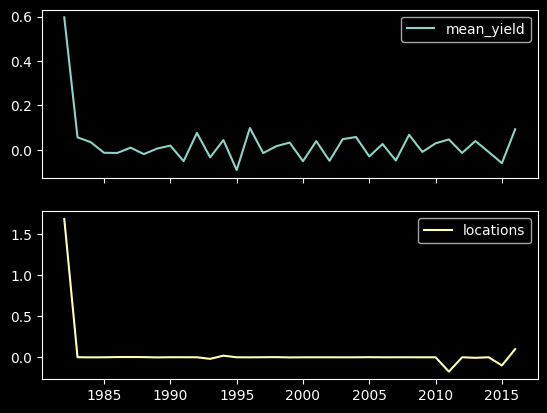

In [49]:
features_stationarity_pipeline.fit_transform(yields.copy()).plot(subplots=True);

## Feature Engineering Pipeline

Now let's create some features. We won't go too much into the details of time series forecasting. We will mainly focus on leveraging all the methods from Sklearn to build professional pipelines.

In [57]:
def rolling_average_transformer(X: Union[pd.Series, pd.DataFrame], window: int = 5):
    """Compute the moving average with a length of 'window'."""

    if isinstance(X, pd.Series):
        X = X.to_frame()

    X_average = X.rolling(window=window).mean()
    X_average.columns = [f"{col}_rolling_average_{window}" for col in X.columns]

    logger.debug(f"rolling_average_transformer (transform): {X_average.shape}")

    return X_average


def rolling_std_transformer(X: Union[pd.Series, pd.DataFrame], window: int = 5):
    """Compute the moving standard deviation with a length of 'window'."""

    if isinstance(X, pd.Series):
        X = X.to_frame()

    X_std = X.rolling(window=window).std()
    X_std.columns = [f"{col}_rolling_std_{window}" for col in X.columns]

    logger.debug(f"rolling_std_transformer (transform): {X_std.shape}")

    return X_std


def rolling_median_transformer(X: Union[pd.Series, pd.DataFrame], window: int = 5):
    """Compute the moving median with a length of 'window'."""

    if isinstance(X, pd.Series):
        X = X.to_frame()

    X_median = X.rolling(window=window).median()
    X_median.columns = [f"{col}_rolling_median_{window}" for col in X.columns]

    logger.debug(f"rolling_median_transformer (transform): {X_median.shape}")

    return X_median


def time_series_shift(X: Union[pd.Series, pd.DataFrame], n_past: int = 5):
    """Function that gathers 'n_past' points to predict the point at time T_n."""

    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    if isinstance(X, pd.Series):
        X = X.to_frame()

    encoded_X = X.copy()
    for column in X.columns:
        for past_delta in range(1, n_past + 1):
            column_name = f"{column}_{past_delta}"
            X_delta = X[column].shift(past_delta)
            X_delta = X_delta.rename(column_name)

            encoded_X = pd.concat([encoded_X, X_delta], axis=1)

    # Now drop all the columns from time T_n. We want to keep at the feature level T_n-1, T_n-2, ... T_0 and predict the value at time T_n.
    encoded_X = encoded_X.drop(columns=X.columns)

    logger.debug(f"time_series_shift (transform): {encoded_X.shape}")

    return encoded_X


class DropRowsTransformer(BaseEstimator, TransformerMixin):
    """Transformer used to drop a given number of rows from the beginning of the DataFrame."""

    def __init__(self, num_rows: int):
        """

        Args:
            num_rows: The number of rows to drop at the beginning of the structure.
        """

        self.num_rows = num_rows
        self.start_X = None

    def fit(self, X: pd.DataFrame, y: Optional[Union[pd.DataFrame, pd.Series]] = None) -> "DropRowsTransformer":
        self.start_X = X.iloc[:self.num_rows]

        logger.debug(f"DropRowsTransformer X (fit): {X.shape}")
        if y is not None:
            logger.debug(f"DropRowsTransformer y (fit): {y.shape}")

        return self

    def transform(self, X: Union[np.ndarray, pd.Series, pd.DataFrame]) -> pd.DataFrame:
        if isinstance(X, np.ndarray):
            X = X[self.num_rows: ]
        else:
            X = X.iloc[self.num_rows: ]

        logger.debug(f"DropRowsTransformer (transform): {X.shape}")

        return X

    def inverse_transform(self, X: Union[np.ndarray, pd.Series, pd.DataFrame]) -> pd.DataFrame:
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        X = pd.concat([self.start_X, X], axis=0)

        logger.debug(f"DropRowsTransformer (inverse_transform): {X.shape}")

        return X


RollingAverageTransformer = FunctionTransformer(partial(rolling_average_transformer, window=NUM_OBSERVED_POINTS))
RollingStdTransformer = FunctionTransformer(partial(rolling_std_transformer, window=NUM_OBSERVED_POINTS))
RollingMedianTransformer = FunctionTransformer(partial(rolling_median_transformer, window=NUM_OBSERVED_POINTS))
ShiftNumObservedPointsTransformer = FunctionTransformer(partial(time_series_shift, n_past=NUM_OBSERVED_POINTS))
ShiftOnePointTransformer = FunctionTransformer(partial(time_series_shift, n_past=1))

For most of the transformation we used plain functions + `FunctionTransformer`. We used this approach because we are not interested in implementing `fit` or `inverse_transform`. Therefore, using this method, our code is slimmer and cleaner.

Only `DropRowsTransformer` is implemented with a class because it needs both `fit` and `inverse_transform`.

Now let's get to the sweet part where we will use:
* [make_column_transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) (a shortcut for [ColumnTransfomer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html))
* [make_union](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_union.html) (a shortcut for [FeatureUnion](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html))

Using `make_column_transformer` we can run different operations/pipelines on subsets of the features. In this concrete example, we ran various transformations on the `mean_yield` and the `locations` fields. Another sweet thing about this is that it runs in `parallel`. The features for `mean_yield` and `locations` are computed in `parallel`.

Using `make_union` we can compute multiple features in parallel. In this example, for `mean_yield` we are calculating in `parallel` for four different features:
* past observations
* moving average
* moving standard deviation
* moving median
The same principle applies to the `locations` feature.

All the features are computed in `parallel`. `make_column_transformer` runs the operations for `mean_yield` and `locations` in parallel. Afterward, `make_pipeline` calculates all the features in parallel. This is how powerful Sklearn pipelines are if used correctly.

As the cherry on top, by setting `memory=cache` the outputs from intermediary steps are saved on disk. It knows when to invalidate the check if one pipeline unit changes.

Also, by following the Sklearn interface and good practices, look at how easy is to compose those transformation for various features.

In [58]:
def build_feature_engineering_pipeline() -> Pipeline:
    """Factory function used to build the feature engineering pipeline."""

    return make_pipeline(
        build_stationarity_pipeline(source="features"),
        make_column_transformer(
            (
                make_union(
                    ShiftNumObservedPointsTransformer,
                    make_pipeline(RollingAverageTransformer, ShiftOnePointTransformer),
                    make_pipeline(RollingStdTransformer, ShiftOnePointTransformer),
                    make_pipeline(RollingMedianTransformer, ShiftOnePointTransformer)
                ),
                ["mean_yield"]
            ),
            (
                make_union(
                    ShiftNumObservedPointsTransformer,
                    make_pipeline(RollingAverageTransformer, ShiftOnePointTransformer)
                ),
                ["locations"]
            ),

        ),
        BackFillImputer,
        ForwardFillImputer,
        DropRowsTransformer(num_rows=NUM_OBSERVED_POINTS),
        memory="cache",
        verbose=True
    )

feature_engineering_pipeline = build_feature_engineering_pipeline()
feature_engineering_pipeline

Pipeline(memory='cache',
         steps=[('pipeline',
                 Pipeline(memory='cache',
                          steps=[('functiontransformer-1',
                                  FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7fa2fb7c8220>, method='bfill'))),
                                 ('functiontransformer-2',
                                  FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7fa2fb7c8220>, method='ffill'))),
                                 ('logtransfo...
                                                  ['locations'])])),
                ('functiontransformer-1',
                 FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7fa2fb7c8220>, method='bfill'))),
                ('functiontransformer-2',
                 FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7fa2fb7c8220>, method='ffill'))),
                ('droprowstransformer', DropRowsTransformer(num_rows=5))],
         verbose=True)

In [59]:
feature_engineered_yields = feature_engineering_pipeline.fit_transform(X_train.copy())
feature_engineered_yields

DEBUG:sklearn-pipelines:time_series_shift (transform): (31, 5)
DEBUG:sklearn-pipelines:rolling_average_transformer (transform): (31, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (31, 1)
DEBUG:sklearn-pipelines:rolling_std_transformer (transform): (31, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (31, 1)
DEBUG:sklearn-pipelines:rolling_median_transformer (transform): (31, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (31, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (31, 5)
DEBUG:sklearn-pipelines:rolling_average_transformer (transform): (31, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (31, 1)
DEBUG:sklearn-pipelines:DropRowsTransformer X (fit): (31, 14)
DEBUG:sklearn-pipelines:DropRowsTransformer (transform): (26, 14)


[Pipeline] . (step 2 of 5) Processing columntransformer, total=   0.1s
[Pipeline]  (step 5 of 5) Processing droprowstransformer, total=   0.0s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
5,-0.013690,-0.013000,0.034739,0.056611,0.596868,0.132306,0.261484,0.034739,0.002453,-0.000238,-0.001108,0.001029,1.683205,0.337068
6,0.010093,-0.013690,-0.013000,0.034739,0.056611,0.014951,0.030628,0.010093,0.002683,0.002453,-0.000238,-0.001108,0.001029,0.000964
7,-0.018987,0.010093,-0.013690,-0.013000,0.034739,-0.000169,0.022502,-0.013000,0.001811,0.002683,0.002453,-0.000238,-0.001108,0.001120
8,0.005931,-0.018987,0.010093,-0.013690,-0.013000,-0.005931,0.013020,-0.013000,-0.001496,0.001811,0.002683,0.002453,-0.000238,0.001043
9,0.019365,0.005931,-0.018987,0.010093,-0.013690,0.000542,0.016267,0.005931,0.000551,-0.001496,0.001811,0.002683,0.002453,0.001200
10,-0.050680,0.019365,0.005931,-0.018987,0.010093,-0.006856,0.028311,0.005931,0.000394,0.000551,-0.001496,0.001811,0.002683,0.000789
11,0.076288,-0.050680,0.019365,0.005931,-0.018987,0.006383,0.047316,0.005931,0.000000,0.000394,0.000551,-0.001496,0.001811,0.000252
12,-0.033395,0.076288,-0.050680,0.019365,0.005931,0.003502,0.049630,0.005931,-0.019071,0.000000,0.000394,0.000551,-0.001496,-0.003924
13,0.044243,-0.033395,0.076288,-0.050680,0.019365,0.011164,0.052945,0.019365,0.019464,-0.019071,0.000000,0.000394,0.000551,0.000268
14,-0.090670,0.044243,-0.033395,0.076288,-0.050680,-0.010843,0.069091,-0.033395,-0.000079,0.019464,-0.019071,0.000000,0.000394,0.000142


In [65]:
# Notice we are not using fit_transform() here. We want to use the same parameters as the ones used in the training set.
feature_engineering_pipeline.transform(X_test.copy())

DEBUG:sklearn-pipelines:time_series_imputer (transform): (10, 2)
/tmp/ipykernel_15604/3468867238.py:123: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return X.fillna(method=method, axis=0)
DEBUG:sklearn-pipelines:time_series_imputer (transform): (10, 2)


DEBUG:sklearn-pipelines:LogTransformer (transform): (10, 2)
DEBUG:sklearn-pipelines:DifferenceTransformer (transform): (9, 2)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 5)
DEBUG:sklearn-pipelines:rolling_average_transformer (transform): (9, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 1)
DEBUG:sklearn-pipelines:rolling_std_transformer (transform): (9, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 1)
DEBUG:sklearn-pipelines:rolling_median_transformer (transform): (9, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 5)
DEBUG:sklearn-pipelines:rolling_average_transformer (transform): (9, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 1)
DEBUG:sklearn-pipelines:time_series_imputer (transform): (9, 14)
/tmp/ipykernel_15604/3468867238.py:123: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
5,-0.013739,0.047205,0.029618,-0.009181,0.067863,0.024353,0.035421,0.029618,0.000000,-0.174841,-0.000157,-0.000393,0.000157,-0.035047
6,0.039902,-0.013739,0.047205,0.029618,-0.009181,0.018761,0.028332,0.029618,-0.006490,0.000000,-0.174841,-0.000157,-0.000393,-0.036376
7,-0.009268,0.039902,-0.013739,0.047205,0.029618,0.018744,0.028354,0.029618,0.000000,-0.006490,0.000000,-0.174841,-0.000157,-0.036298
8,-0.059606,-0.009268,0.039902,-0.013739,0.047205,0.000899,0.043715,-0.009268,-0.099632,0.000000,-0.006490,0.000000,-0.174841,-0.056192


# Modeling

## Regressor Pipeline

In [101]:
def build_regressor_pipeline() -> Pipeline:
    """
    Factory function used to build the final regressor.

    One key thing is that the model (e.g., RandomForestRegressor) should always be the last unit within the pipeline.

    Otherwise, you can compose the transformations how you wish.
    """

    return make_pipeline(
        build_feature_engineering_pipeline(),
        MinMaxScaler(),
        RandomForestRegressor(n_estimators=100),
        memory="cache",
        verbose=True
    )

training_pipeline = build_regressor_pipeline()
training_pipeline

Pipeline(memory='cache',
         steps=[('pipeline',
                 Pipeline(memory='cache',
                          steps=[('pipeline',
                                  Pipeline(memory='cache',
                                           steps=[('functiontransformer-1',
                                                   FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7fa2fb7c8220>, method='bfill'))),
                                                  ('functiontransformer-2',
                                                   FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7...
                                  FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7fa2fb7c8220>, method='bfill'))),
                                 ('functiontransformer-2',
                                  FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7fa2fb7c8220>, method='ffill'))),
                                 ('droprowstransformer',
                                  DropRowsTransformer(num_rows=5))],
                          verbose=True)),
                ('minmaxscaler', MinMaxScaler()),
                ('randomforestregressor', RandomForestRegressor())],
         verbose=True)

## Target Pipeline

In [102]:
def build_target_pipeline() -> Pipeline:
    """Factory function used to build the target (e.g., y) pipeline."""

    return make_pipeline(build_stationarity_pipeline(source="target"), memory="cache", verbose=True)

target_pipeline = build_target_pipeline()
target_pipeline

Pipeline(memory='cache',
         steps=[('pipeline',
                 Pipeline(memory='cache',
                          steps=[('functiontransformer-1',
                                  FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7fa2fb7c8220>, method='bfill'))),
                                 ('functiontransformer-2',
                                  FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7fa2fb7c8220>, method='ffill'))),
                                 ('logtransformer', LogTransformer()),
                                 ('differencetransformer',
                                  DifferenceTransformer(num_observed_points=0))],
                          verbose=True))],
         verbose=True)

## Global Pipeline (Put Things Together)

Here we will show how to use:
* [TransformedTargetRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html)

This is extremely useful when performing different operations on the target. In our case, we had to transform the time series to make it stationary.

The sweet part about this wrapper is that it calls `fit_transform` while training and calls `inverse_transform` when making predictions. Therefore, this can unify your model into a single structure. In the end, the model will be straightforward to use and deploy. You will just have to call `model.predict(X)`, and the predictions are ready to be used in your application.

In [103]:
def build_global_pipeline() -> Pipeline:
    """Factory function used to build the final pipeline."""

    return make_pipeline(
        TransformedTargetRegressor(
            regressor=build_regressor_pipeline(),
            transformer=build_target_pipeline(),
            check_inverse=False
        ),
        memory="cache",
        verbose=True
    )

pipeline = build_global_pipeline()
pipeline

Pipeline(memory='cache',
         steps=[('transformedtargetregressor',
                 TransformedTargetRegressor(check_inverse=False,
                                            regressor=Pipeline(memory='cache',
                                                               steps=[('pipeline',
                                                                       Pipeline(memory='cache',
                                                                                steps=[('pipeline',
                                                                                        Pipeline(memory='cache',
                                                                                                 steps=[('functiontransformer-1',
                                                                                                         FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7fa2fb7c8220>, m...
                                                                                          FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7fa2fb7c8220>, method='bfill'))),
                                                                                         ('functiontransformer-2',
                                                                                          FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7fa2fb7c8220>, method='ffill'))),
                                                                                         ('logtransformer',
                                                                                          LogTransformer()),
                                                                                         ('differencetransformer',
                                                                                          DifferenceTransformer(num_observed_points=0))],
                                                                                  verbose=True))],
                                                                 verbose=True)))],
         verbose=True)

In [104]:
pipeline.named_steps

{'transformedtargetregressor': TransformedTargetRegressor(check_inverse=False,
                            regressor=Pipeline(memory='cache',
                                               steps=[('pipeline',
                                                       Pipeline(memory='cache',
                                                                steps=[('pipeline',
                                                                        Pipeline(memory='cache',
                                                                                 steps=[('functiontransformer-1',
                                                                                         FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7fa2fb7c8220>, method='bfill'))),
                                                                                        ('functiontransformer-2',
                                                                                         FunctionTran

## Train

Now the fitting/training step is a one-liner.

In [105]:
pipeline.fit(X=X_train.copy(), y=y_train.copy());

DEBUG:sklearn-pipelines:time_series_imputer (transform): (27, 1)
/tmp/ipykernel_15604/3468867238.py:123: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return X.fillna(method=method, axis=0)
DEBUG:sklearn-pipelines:time_series_imputer (transform): (27, 1)
DEBUG:sklearn-pipelines:LogTransformer X (fit): (27, 1)
DEBUG:sklearn-pipelines:LogTransformer (transform): (27, 1)
DEBUG:sklearn-pipelines:DifferenceTransformer X (fit): (27, 1)
DEBUG:sklearn-pipelines:time_series_imputer (transform): (27, 1)
/tmp/ipykernel_15604/3468867238.py:123: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return X.fillna(method=method, axis=0)
DEBUG:sklearn-pipelines:time_series_imputer (transform): (27, 1)
DEBUG:sklearn-pipelines:LogTransformer (transform): (27, 1)
DEBUG:sklearn-pipelines:DifferenceTransformer (transform): (26, 1)


[Pipeline]  (step 1 of 4) Processing functiontransformer-1, total=   0.0s
[Pipeline]  (step 2 of 4) Processing functiontransformer-2, total=   0.0s
[Pipeline] .... (step 3 of 4) Processing logtransformer, total=   0.0s
[Pipeline]  (step 4 of 4) Processing differencetransformer, total=   0.0s
[Pipeline] .......... (step 1 of 1) Processing pipeline, total=   0.3s


DEBUG:sklearn-pipelines:time_series_imputer (transform): (32, 2)
DEBUG:sklearn-pipelines:time_series_imputer (transform): (32, 2)
/tmp/ipykernel_15604/3468867238.py:123: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return X.fillna(method=method, axis=0)
DEBUG:sklearn-pipelines:LogTransformer X (fit): (32, 2)
DEBUG:sklearn-pipelines:LogTransformer y (fit): (26,)
DEBUG:sklearn-pipelines:LogTransformer (transform): (32, 2)
DEBUG:sklearn-pipelines:DifferenceTransformer X (fit): (32, 2)
DEBUG:sklearn-pipelines:DifferenceTransformer y (fit): (26,)
DEBUG:sklearn-pipelines:DifferenceTransformer (transform): (31, 2)


[Pipeline]  (step 1 of 4) Processing functiontransformer-1, total=   0.0s
[Pipeline]  (step 2 of 4) Processing functiontransformer-2, total=   0.0s
[Pipeline] .... (step 3 of 4) Processing logtransformer, total=   0.0s
[Pipeline]  (step 4 of 4) Processing differencetransformer, total=   0.0s
[Pipeline] .......... (step 1 of 5) Processing pipeline, total=   0.2s


DEBUG:sklearn-pipelines:time_series_shift (transform): (31, 5)
DEBUG:sklearn-pipelines:rolling_average_transformer (transform): (31, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (31, 1)
DEBUG:sklearn-pipelines:rolling_std_transformer (transform): (31, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (31, 1)
DEBUG:sklearn-pipelines:rolling_median_transformer (transform): (31, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (31, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (31, 5)
DEBUG:sklearn-pipelines:rolling_average_transformer (transform): (31, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (31, 1)
DEBUG:sklearn-pipelines:time_series_imputer (transform): (31, 14)
/tmp/ipykernel_15604/3468867238.py:123: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return X.fillna(method=method, axis=0)
DEBUG:sklearn-pipelines:time_series_imputer (transfo

[Pipeline] . (step 2 of 5) Processing columntransformer, total=   0.0s
[Pipeline]  (step 3 of 5) Processing functiontransformer-1, total=   0.0s
[Pipeline]  (step 4 of 5) Processing functiontransformer-2, total=   0.0s
[Pipeline]  (step 5 of 5) Processing droprowstransformer, total=   0.0s
[Pipeline] .......... (step 1 of 3) Processing pipeline, total=   0.5s
[Pipeline] ...... (step 2 of 3) Processing minmaxscaler, total=   0.0s
[Pipeline]  (step 3 of 3) Processing randomforestregressor, total=   0.1s
[Pipeline]  (step 1 of 1) Processing transformedtargetregressor, total=   1.2s


## Make Predictions

The sweet part, is that also, the prediction step is a one liner.

As stated above, using `TransformedTargetRegressor` the predictions are already transformed back to their initial scale when calling `predict`. Therefore, the model/pipeline is highly compact and easy to deploy in various scenarios: batch, API, streaming, embedded, etc.

Another helpful feature is that now, you can quickly use a `GridSearch` (or other technique) on your features and model. You can quickly experiment with various features with only a few lines of code.

In [106]:
y_pred = pipeline.predict(X_test.copy())

DEBUG:sklearn-pipelines:time_series_imputer (transform): (10, 2)
/tmp/ipykernel_15604/3468867238.py:123: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return X.fillna(method=method, axis=0)
DEBUG:sklearn-pipelines:time_series_imputer (transform): (10, 2)
DEBUG:sklearn-pipelines:LogTransformer (transform): (10, 2)
DEBUG:sklearn-pipelines:DifferenceTransformer (transform): (9, 2)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 5)
DEBUG:sklearn-pipelines:rolling_average_transformer (transform): (9, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 1)
DEBUG:sklearn-pipelines:rolling_std_transformer (transform): (9, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 1)
DEBUG:sklearn-pipelines:rolling_median_transformer (transform): (9, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 5)
DEBUG:

In [107]:
y_pred

26    4.026584
0     4.088741
1     4.040883
2     4.093186
3     4.311492
Name: 0, dtype: float64

In [108]:
y_test

2012    4.026584
2013    4.190502
2014    4.151844
2015    3.911601
2016    4.293674
Name: mean_yield, dtype: float32

## Test

In [113]:
def evaluate(y_test, y_pred):
    y_test = y_test.iloc[-SIZE_TEST_SPLIT:]
    y_pred = y_pred.iloc[-SIZE_TEST_SPLIT:]

    logger.info(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.6f}")
    logger.info(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred):.6f}")

In [114]:
evaluate(y_test, y_pred)

INFO:sklearn-pipelines:RMSE: 0.118277
INFO:sklearn-pipelines:MAPE: 0.025395


For the sweet of the art, let's evaluate our model.

We can observe that it is doing decent work using a simple model and without any fine-tuning at all. An RMSE of ~0.13 on a scale of ~4.0 is pretty good.

But this notebook was about leveraging Sklearn Pipelines, not building a good model.

# Conclusion

Using a concrete example, we showed how powerful it is to leverage Sklearn Pipelines and their entire stack of features: TransformerMixin , BaseEstimator, FunctionTransformer, ColumnTransformer,FeatureUnion, TransformedTargetRegressor.

We can use this approach to:
* Easily reuse the transformation and compose them in various scenarios.
* Write clean and scalable code.
* Quickly cache intermediate checkpoints across the pipeline.
* Directly deploy the model as a simple function without further preprocessing/postprocessing steps
* Quickly perform hyper-parameter tunning on both the feature pipeline and the model itself.

##### What other hidden gems do you know about Sklearn Pipelines?